In [1]:
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.utils import shuffle
arr = lambda x: np.array(x)
font = {'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
def create_data(d=5, p=1, n=1000, deg=1, n_test=2000):

    Cx = np.eye(d)#np.diag(np.random.rand(d,))#+randX.T@randX/N
    Cy = 2*np.eye(p)#np.diag(np.random.rand(p,))*1
    Lx = np.linalg.cholesky(Cx)
    Ly = np.linalg.cholesky(Cy)

    X_tr = np.random.randn(n, d)@Lx
    X_te = np.random.randn(n_test, d)@Lx
    
    
    w_true = np.random.randn(X_tr.shape[1],p)
    Y_tr = (X_tr**3)@w_true + np.random.randn(n,p)@Ly
    Y_te = (X_te**3)@w_true + np.random.randn(n_test,p)@Ly
    
    X_te = np.hstack([X_te**i for i in range(1, deg+1)])
    X_tr = np.hstack([X_tr**i for i in range(1, deg+1)])
    
    if deg > 1:
        zero = np.zeros((d*(deg-1), p))
        w_true = np.vstack([w_true, zero])
    assert w_true.shape[0] == X_tr.shape[1]
    return X_tr, Y_tr, X_te, Y_te#, w_true, Cx, Cy

In [3]:
def generate_data(case='regression', sparse=False):
    """Generate regression/classification data."""
    bunch = datasets.load_boston()
    X, y = shuffle(bunch.data, bunch.target)
    offset = int(X.shape[0] * 0.6)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test).reshape(-1, 1)
    y_train = np.array(y_train).reshape(-1, 1)
    data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}
    return X_train, y_train, X_test, y_test

In [4]:
def compute_V_C(X, y, lanbda, w):
    n, d = X.shape
    p = y.shape[1]
    V = np.zeros((d, d))
    mean_grad = np.zeros((d, p))
    for i in range(n):
        grad_i = np.outer(X[i], X[i]@w-y[i])+lanbda*w
        assert grad_i.shape == w.shape
        mean_grad += grad_i/n
        V += grad_i@grad_i.T/n
    C = V - mean_grad@mean_grad.T
    return V, C

In [5]:

def eval_lanbda(lanbda):
    gaps = []
    tics = []
    losses_te = []
    losses_tr = []
    for i in range(500):
        X_train, y_train, X_test, y_test = create_data()#generate_data()
        #lanbda = 1e-4
        # get the w_mle
        hessian = lambda x: x.T@x/x.shape[0] + lanbda*np.eye(x.shape[1])
        H_train = hessian(X_train)
#         H_test = hessian(X_test)
        inv_H_train = np.linalg.inv(H_train)
        w_mle = inv_H_train@X_train.T@y_train/X_train.shape[0]
        # get the gap
        loss = lambda x, y, w: 1/(2*x.shape[0])*np.sum((x@w - y)**2) + lanbda/2*np.trace(w_mle.T@w_mle)
        loss_tr = loss(X_train, y_train, w_mle)
        loss_te = loss(X_test, y_test, w_mle)
        gap = loss_te - loss_tr
        #print(gap)
        _, C_train = compute_V_C(X_train, y_train, lanbda, w_mle)
#         _, C_test = compute_V_C(X_test, y_test, lanbda, w_mle)
        tic = np.trace(inv_H_train@C_train)/X_train.shape[0]
#         tic_te = np.trace(np.linalg.inv(H_test)@C_test)/X_test.shape[0]
        gaps.append(gap)
        tics.append(tic)
        losses_te.append(loss_te)
        losses_tr.append(loss_tr)
    gaps, tics = np.array(gaps), np.array(tics)
    losses_tr, losses_te = np.array(losses_tr), np.array(losses_te)
    return gaps.mean(), tics.mean(), gaps.std(), tics.std(), losses_tr.mean(), losses_te.mean(), losses_tr.std(), losses_te.std()


In [6]:
def eval_deg(deg, lanbda=0):
    tics_te = []
    tics = []
    losses_te = []
    losses_tr = []
    for i in range(500):
        X_train, y_train, X_test, y_test = create_data(deg=deg)#generate_data()
        #lanbda = 1e-4
        # get the w_mle
        hessian = lambda x: x.T@x/x.shape[0] + lanbda*np.eye(x.shape[1])
        H_train = hessian(X_train)
        H_test = hessian(X_test)
        inv_H_train = np.linalg.inv(H_train)
        w_mle = inv_H_train@X_train.T@y_train/X_train.shape[0]
        # get the gap
        loss = lambda x, y, w: 1/(2*x.shape[0])*np.sum((x@w - y)**2) + lanbda/2*np.trace(w_mle.T@w_mle)
        loss_tr = loss(X_train, y_train, w_mle)
        loss_te = loss(X_test, y_test, w_mle)
        gap = loss_te - loss_tr
        #print(gap)
        _, C_train = compute_V_C(X_train, y_train, lanbda, w_mle)
        _, C_test = compute_V_C(X_test, y_test, lanbda, w_mle)
        tic = np.trace(inv_H_train@C_train)/X_train.shape[0]
        tic_te = np.trace(np.linalg.inv(H_test)@C_test)/X_test.shape[0]
#         gaps.append(gap)
        tics.append(tic)
        tics_te.append(tic_te)
        losses_te.append(loss_te)
        losses_tr.append(loss_tr)
    tics_te, tics = np.array(tics_te), np.array(tics)
    losses_tr, losses_te = np.array(losses_tr), np.array(losses_te)
    return tics_te.mean(), tics.mean(), tics_te.std(), tics.std(), losses_tr.mean(), losses_te.mean(), losses_tr.std(), losses_te.std()

In [7]:
mu_tics_te, std_tics_te = [], []
mu_tics, std_tics = [], []
mu_losses_tr, std_losses_tr = [], []
mu_losses_te, std_losses_te = [], []
results = {}

# lanbdas = np.logspace(-5, 1, 10)
# for lan in lanbdas:
lanbdas = np.arange(10)+1
for lan in lanbdas:
    print(lan)
    mu_tic_te, mu_tic, std_tic_te, std_tic, mu_loss_tr, mu_loss_te, std_loss_tr, std_loss_te = eval_deg(lan)
    mu_tics_te.append(mu_tic_te)
    mu_tics.append(mu_tic)
    std_tics_te.append(std_tic_te)
    std_tics.append(std_tic)
    mu_losses_tr.append(mu_loss_tr)
    mu_losses_te.append(mu_loss_te)
    std_losses_tr.append(std_loss_tr)
    std_losses_te.append(std_loss_te)


1
2
3
4
5
6
7
8
9
10


In [8]:
mu_gaps, std_gaps = arr(mu_losses_te) - arr(mu_losses_tr), np.sqrt(arr(std_losses_te)**2+arr(std_losses_tr)**2)

In [9]:
eps=0.1

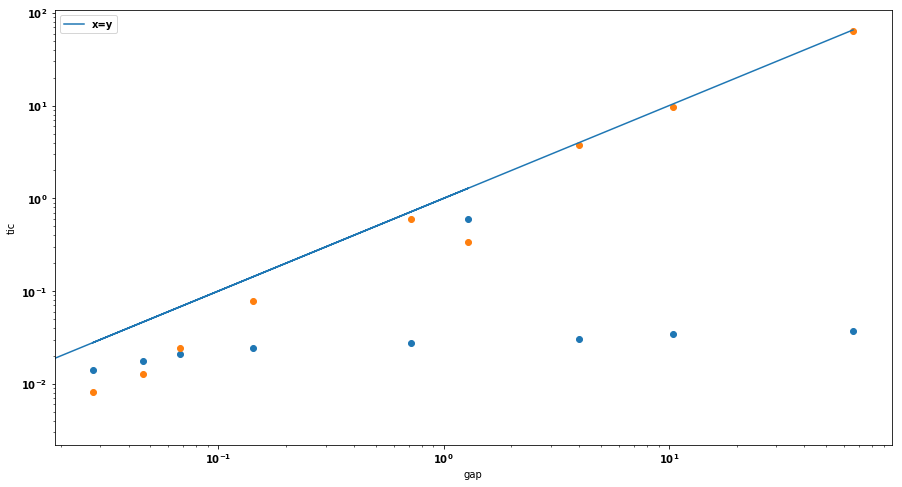

In [10]:
# plt.plot(mu_gaps, mu_tics, 'o-', color='xkcd:blue')
plt.figure(figsize=(15,8))   
plt.scatter(mu_gaps, arr(mu_tics)/2)
plt.scatter(mu_gaps, arr(mu_tics_te)/2)
# plt.errorbar(mu_gaps, mu_tics, marker='o', xerr=eps*arr(std_gaps), yerr=eps*arr(std_tics), label='train')
# plt.errorbar(mu_gaps, mu_tics_te, marker='o', xerr=eps*arr(std_gaps), yerr=eps*arr(std_tics_te), label='test')
plt.plot(mu_gaps, mu_gaps, label='x=y')
plt.xlabel('gap')
plt.legend()
plt.ylabel('tic')
plt.xscale('log')
plt.yscale('log')

Text(0,0.5,'gap')

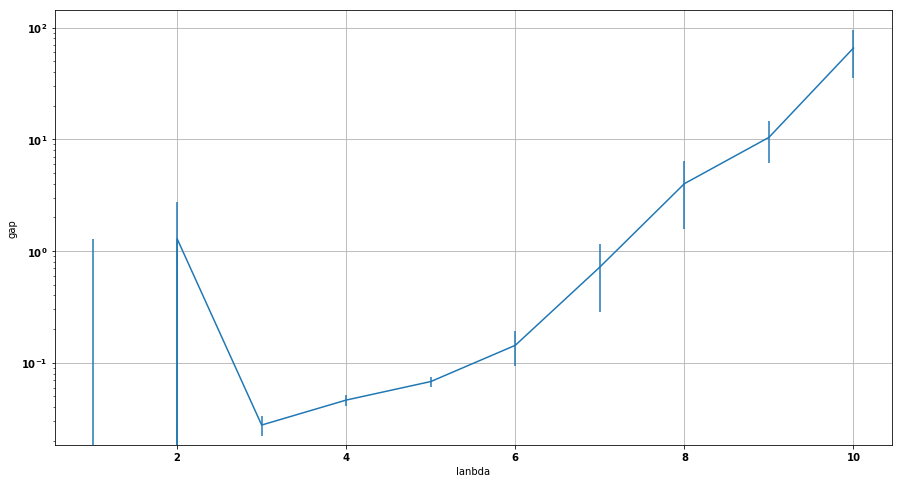

In [11]:
# plt.semilogx(lanbdas, mu_gaps, 'o-', color='xkcd:blue')
plt.figure(figsize=(15,8))   
plt.errorbar(lanbdas, mu_gaps, yerr=eps*arr(std_gaps))
plt.grid()
plt.xlabel('lanbda')
plt.yscale('log')
plt.ylabel('gap')

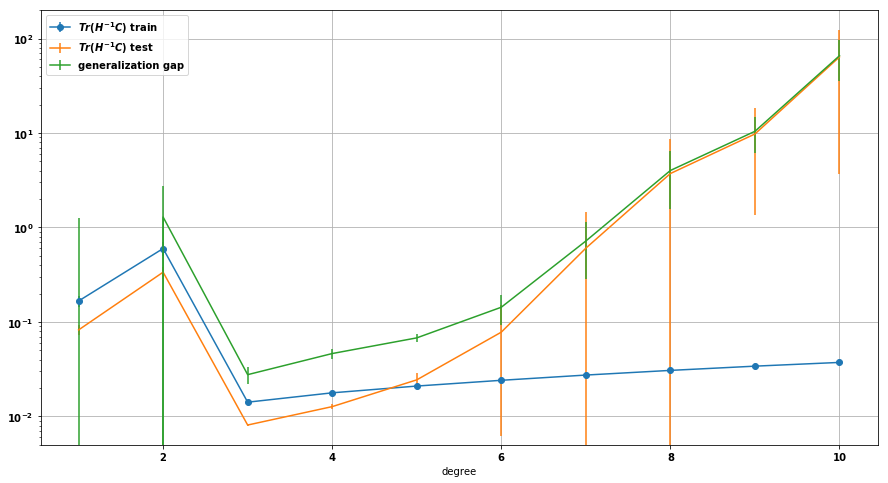

In [12]:
# plt.semilogx(lanbdas, mu_tics, 'o-', color='xkcd:blue')
plt.figure(figsize=(15,8))   
plt.errorbar(lanbdas, arr(mu_tics)/2, marker='o', yerr=eps*arr(std_tics), label=r'$Tr(H^{-1} C)$ train')
plt.errorbar(lanbdas, arr(mu_tics_te)/2, yerr=eps*arr(std_tics_te), label=r'$Tr(H^{-1} C)$ test')
plt.errorbar(lanbdas, mu_gaps, yerr=eps*arr(std_gaps), label='generalization gap')

# plt.plot(lanbdas, 13*lanbdas/500)
plt.xlabel('degree')
plt.grid()
plt.legend()
plt.yscale('log')
# plt.ylabel('tic')
# plt.savefig('trh1c_te_tr_gap.png')

Text(0,0.5,'loss')

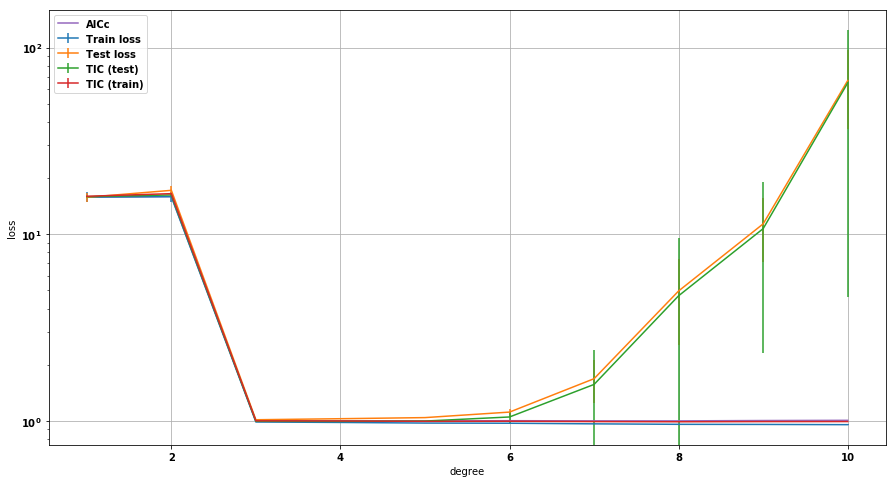

In [13]:
# plt.semilogx(lanbdas, mu_losses_tr, 'o-', color='xkcd:blue')
plt.figure(figsize=(15,8))   
plt.errorbar(lanbdas, mu_losses_tr, yerr=eps*arr(std_losses_tr), label='Train loss')
plt.errorbar(lanbdas, mu_losses_te, yerr=eps*arr(std_losses_te), label='Test loss')
plt.errorbar(lanbdas, arr(mu_losses_tr)+arr(mu_tics_te)/2, yerr=eps*arr(std_tics_te), label='TIC (test)')
plt.errorbar(lanbdas, arr(mu_losses_tr)+arr(mu_tics)/2, yerr=eps*arr(std_tics), label='TIC (train)')
k = 5*lanbdas
n = 1000
aicc = arr(mu_losses_tr) + k/n + (k**2 + k)/((n-k+1)*n)
plt.plot(lanbdas, aicc, label='AICc')
plt.xlabel('degree')
# plt.ylim([0.,1.52])
# plt.xlim([3, 8])
plt.grid()
# plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.ylabel('loss')
# plt.savefig('info_criterion.png')

In [14]:
arr(mu_losses_tr)+arr(mu_tics_te)/2

array([15.91061977, 16.25645262,  0.99441996,  0.9934454 ,  0.99765112,
        1.04926462,  1.56792139,  4.68330936, 10.72483288, 64.80836574])

In [15]:
mu_losses_te

[15.790315626972951,
 17.209776040050766,
 1.013990785063592,
 1.0270554364136277,
 1.0411025244288499,
 1.1144737366318662,
 1.6829204222545624,
 4.970116649211986,
 11.37522732779224,
 66.70714374101293]

In [16]:
arr(mu_losses_tr)+arr(mu_tics)/2

array([15.99493769, 16.51898494,  1.0004648 ,  0.99852156,  0.99422913,
        0.99539455,  0.99132871,  0.98898327,  0.99105215,  0.99153722])

In [17]:
sns.distplot(np.linalg.eigh(X_train@np.linalg.inv(H_train)@X_train.T)[0])

NameError: name 'X_train' is not defined

In [ ]:
np.sum(np.linalg.eigh(X_train@np.linalg.inv(H_train)@X_train.T)[0]>.1)